# Implementing LeNet-5 in PyTorch

In [ ]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [ ]:
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42

In [ ]:
# hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

# 1. Data

In [ ]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
#transforms = transforms.ToTensor()
transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

In [ ]:
print(f'Training set has {len(train_dataset)} samples')
print(f'Validation set has {len(valid_dataset)} samples')

Training set has 60000 samples
Validation set has 10000 samples


In [ ]:
valid_dataset, test_dataset = torch.utils.data.random_split(valid_dataset, [8000, 2000])

In [ ]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

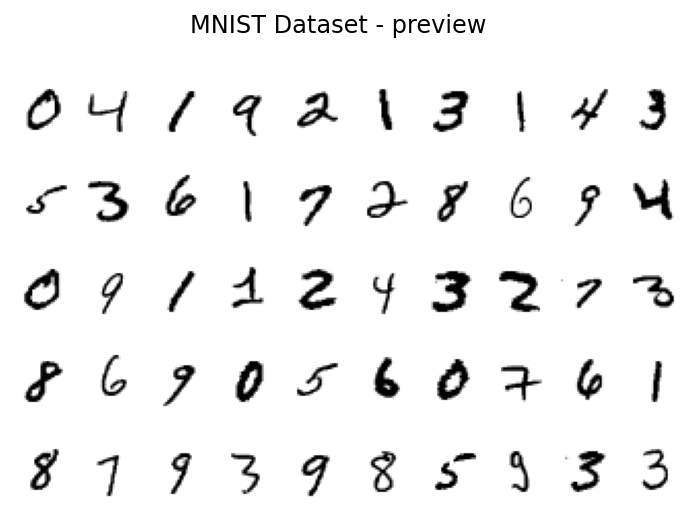

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

# 2. Model

In [ ]:
torch.manual_seed(RANDOM_SEED)

Convolution and pooling are fundamental operations for building CNN models. There are a number of parameters and if their definitions are not clear, it could lead to great confusion.
- Parameters for convolution (pooling) layers
  - **stride:** how many "steps" that the filter makes while "scanning" the input
  - **kernel size**: how large is the kernel (filter) is
  - **number of filters (channels):** designates the "depth" of the data. Most image inputs have three filters (RGB)
  - **padding:** how to pad the input sample with zero in the border
- How to calculate output size of convolution/pooling operation
  <br> 
*(W - F + 2P)/S + 1* <br>
  - *W*: input size
  - *F*: kernel size
  - *P*: padding 
  - *S*: stride


> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">

The Max Pooling 2D   
![alt text](https://user-images.githubusercontent.com/22738317/34081046-c3a97518-e347-11e7-98fe-929f602ee857.png)

For this example, the Average Pooling is used because it is defined in the original LeNet-5 architecture. It takes the average of the elements in its receptive field, while "sliding" through the input. 

Additionally, Tanh activation function is used within the layers and Softmax is used for the output layer.

Conv 2D in PyTorch

**torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)**

* in_channels (int) – Number of channels in the input image

* out_channels (int) – Number of channels produced by the convolution

* kernel_size (int or tuple) – Size of the convolving kernel

* stride (int or tuple, optional) – Stride of the convolution. Default: 1

* padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0

* padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

* dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

* groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

* bias (bool, optional) – If True, adds a learnable bias to the output. Default: True




**LeNet-5 architecture:**

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-52-17.png)

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
model = LeNet5(N_CLASSES).to(DEVICE)
print(model)

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
from torchsummary import summary

summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 3. Training

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

09:30:33 --- Epoch: 0	Train loss: 0.2301	Valid loss: 0.0918	Train accuracy: 97.26	Valid accuracy: 97.00
09:31:09 --- Epoch: 1	Train loss: 0.0765	Valid loss: 0.0728	Train accuracy: 97.92	Valid accuracy: 97.83
09:31:46 --- Epoch: 2	Train loss: 0.0533	Valid loss: 0.0552	Train accuracy: 98.53	Valid accuracy: 98.25
09:32:23 --- Epoch: 3	Train loss: 0.0422	Valid loss: 0.0499	Train accuracy: 99.05	Valid accuracy: 98.44
09:32:59 --- Epoch: 4	Train loss: 0.0351	Valid loss: 0.0527	Train accuracy: 99.14	Valid accuracy: 98.56
09:33:35 --- Epoch: 5	Train loss: 0.0287	Valid loss: 0.0456	Train accuracy: 99.38	Valid accuracy: 98.71
09:34:12 --- Epoch: 6	Train loss: 0.0263	Valid loss: 0.0453	Train accuracy: 99.34	Valid accuracy: 98.61
09:34:49 --- Epoch: 7	Train loss: 0.0209	Valid loss: 0.0549	Train accuracy: 99.19	Valid accuracy: 98.31
09:35:25 --- Epoch: 8	Train loss: 0.0204	Valid loss: 0.0431	Train accuracy: 99.58	Valid accuracy: 98.74
09:36:02 --- Epoch: 9	Train loss: 0.0178	Valid loss: 0.0555	Trai

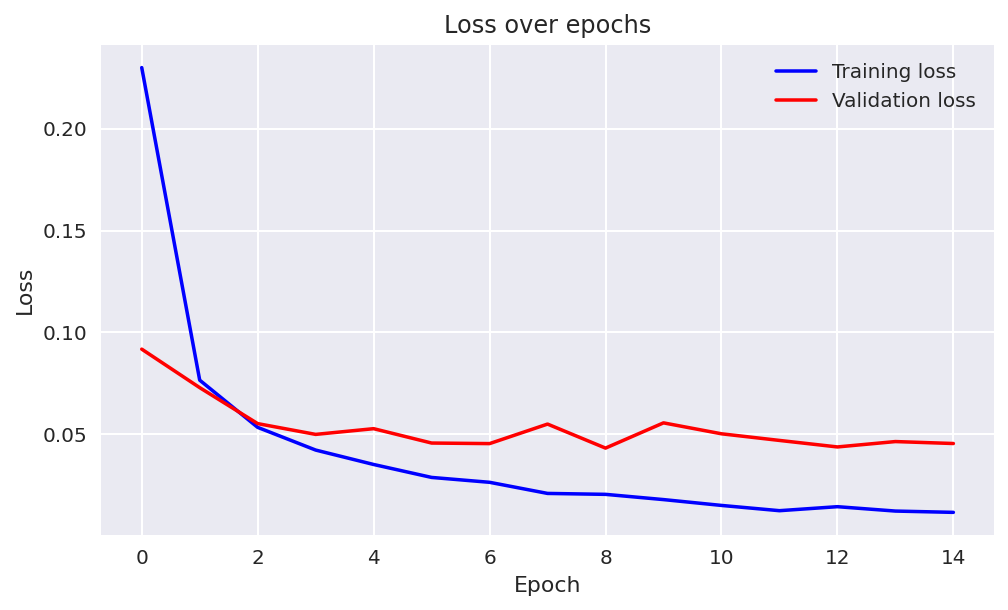

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

# 4. Evaluate

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        _, probs = model(images)
        _, predicted = torch.max(probs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 98.6 %
